In [26]:
#configure dataset
from os import listdir

directory_name = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
image_names = listdir(directory_name)
image_names.remove('.DS_Store')
print(image_names[:5])


['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


In [56]:
#load images
import os, random
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

images_size = len(image_names)

#resizing
images = []
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    image = imresize(image, (115,115)) #should it be good to calculate the mean dimensions??
    images.append(image)

print("Loaded {} images".format(len(images)))

Loaded 990 images


Image 888, Shape:(115, 115, 3)


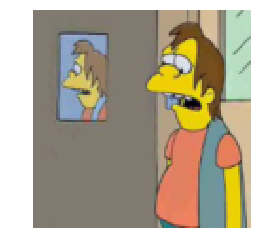

Image 960, Shape:(115, 115, 3)


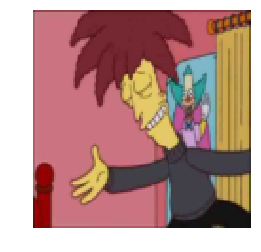

Image 205, Shape:(115, 115, 3)


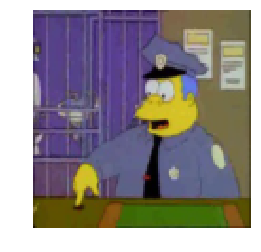

Image 442, Shape:(115, 115, 3)


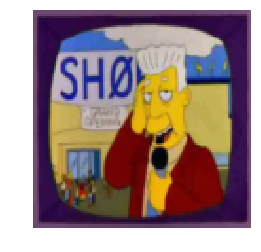

Image 808, Shape:(115, 115, 3)


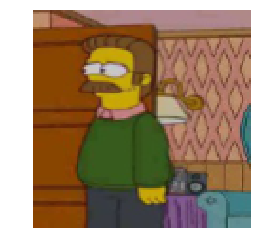

In [60]:
#show some examples
for i in range(1,6):
    idx = random.randint(0, images_size)
    image = images[idx]
    print("Image {}, Shape:{}".format(idx, image.shape))
    plt.imshow(image)
    plt.axis('off')
    plt.show()